# Sports Betting EV Prediction Project

In this project, we analyze historical English Premier League data, build predictive models for match outcomes, calculate expected value (EV) for betting opportunities, and simulate potential profits using backtesting.


### Data Loading and Cleaning

We start by loading English Premier League (EPL) historical match data from Football-Data.org. We select key columns like home/away teams, match results, and bookmaker odds, and compute normalized implied probabilities to adjust for bookmaker overround.


In [141]:
import pandas as pd
import numpy as np

# Load the CSV you provided
df = pd.read_csv('E0.csv')

# Preview the data
print('Historical Premier League Data Preview:')
print(df.head())

# Select key columns
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A']]

# Rename columns for easier handling
df = df.rename(columns={
    'B365H': 'Home_Odds',
    'B365D': 'Draw_Odds',
    'B365A': 'Away_Odds',
    'FTR': 'Result'
})

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Drop rows with missing odds
df = df.dropna(subset=['Home_Odds', 'Draw_Odds', 'Away_Odds'])

# Compute implied probabilities (1/odds)
df['Imp_Prob_Home'] = 1 / df['Home_Odds']
df['Imp_Prob_Draw'] = 1 / df['Draw_Odds']
df['Imp_Prob_Away'] = 1 / df['Away_Odds']

# Normalize probabilities (bookmaker overround adjustment)
df['Total_Imp_Prob'] = df['Imp_Prob_Home'] + df['Imp_Prob_Draw'] + df['Imp_Prob_Away']
# Adjust probabilities to sum up to 1 (normalize)
df['Norm_Prob_Home'] = df['Imp_Prob_Home'] / df['Total_Imp_Prob']
df['Norm_Prob_Draw'] = df['Imp_Prob_Draw'] / df['Total_Imp_Prob']
df['Norm_Prob_Away'] = df['Imp_Prob_Away'] / df['Total_Imp_Prob']

# Encode result: H → 0, D → 1, A → 2
result_map = {'H': 0, 'D': 1, 'A': 2}
df['Result_Code'] = df['Result'].map(result_map)

# Recent Form
def assign_points(row):
    if row['Result'] == 'H':
        return 1, -1
    elif row['Result'] == 'A':
        return -1, 1
    else:
        return 0, 0

# Apply points assignment
df[['Home_Points', 'Away_Points']] = df.apply(assign_points, axis=1, result_type='expand')

# Initialize recent form columns
df['Recent_Form_Home'] = 0.0
df['Recent_Form_Away'] = 0.0

# Number of recent matches to consider in form
N = 10

# Calculate recent form for each team
team_points = {}

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_points = row['Home_Points']
    away_points = row['Away_Points']

    # Initialize team history if not present
    if home_team not in team_points:
        team_points[home_team] = []
    if away_team not in team_points:
        team_points[away_team] = []

    # Calculate recent form as the average of the last N matches
    home_form = team_points[home_team][-N:]
    away_form = team_points[away_team][-N:]
    
    # Calculate average points per game
    if len(home_form) > 0:
        df.loc[index, 'Recent_Form_Home'] = sum(home_form) / len(home_form)
    if len(away_form) > 0:
        df.loc[index, 'Recent_Form_Away'] = sum(away_form) / len(away_form)

    # Update the team's recent matches history
    team_points[home_team].append(home_points)
    team_points[away_team].append(away_points)

df['Total_Team_Form'] = df['Recent_Form_Home'] + df['Recent_Form_Away']
print(df[['Recent_Form_Home', 'Recent_Form_Away', 'Total_Team_Form', 'Result_Code']].corr())

#df['Revised_Home_Prob'] = df['Norm_Prob_Home'] * (1 + (0.1 * df['Recent_Form_Home']))
#df['Revised_Away_Prob'] = df['Norm_Prob_Away'] * (1 + (0.1 * df['Recent_Form_Away']))

                                                                

# Final preview
print('Cleaned Data Preview:')
print(df.head())

# Save cleaned data if needed
df.to_csv('cleaned_epl_data.csv', index=False)


# Test the Distribution of target classes
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)




Historical Premier League Data Preview:
  Div        Date   Time     HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  \
0  E0  11/08/2023  20:00      Burnley       Man City     0     3   A     0   
1  E0  12/08/2023  12:30      Arsenal  Nott'm Forest     2     1   H     2   
2  E0  12/08/2023  15:00  Bournemouth       West Ham     1     1   D     0   
3  E0  12/08/2023  15:00     Brighton          Luton     4     1   H     1   
4  E0  12/08/2023  15:00      Everton         Fulham     0     1   A     0   

   HTAG  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
0     2  ...     2.28  1.50      1.95      1.98   1.95   1.97      NaN   
1     0  ...     2.63 -2.00      1.95      1.98   1.93   1.97     2.01   
2     0  ...     2.12  0.00      2.02      1.91   2.01   1.92     2.06   
3     0  ...     2.48 -1.75      2.01      1.92   2.00   1.91     2.14   
4     0  ...     1.71 -0.25      2.06      1.87   2.04   1.88     2.08   

   MaxCAHA  AvgCAHH  AvgCAHA  
0      NaN     

### Exploratory Data Analysis (EDA)

Before modeling, we explore the data to understand its basic characteristics. We review the distribution of match outcomes (home win, draw, away win) and summarize the odds data to identify any class imbalances or unexpected patterns.


In [ ]:
print("Match outcome counts:")
print(df['Result'].value_counts())

print("\nOdds summary stats:")
print(df[['Home_Odds', 'Draw_Odds', 'Away_Odds']].describe())


Match outcome counts:
Result
H    350
A    246
D    164
Name: count, dtype: int64

Odds summary stats:
        Home_Odds   Draw_Odds   Away_Odds
count  760.000000  760.000000  760.000000
mean     2.908974    4.510000    4.561395
std      2.261127    1.515735    4.007004
min      1.080000    3.000000    1.140000
25%      1.615000    3.600000    2.150000
50%      2.200000    4.000000    3.150000
75%      3.250000    4.750000    5.250000
max     17.000000   12.000000   29.000000


### Model Training and Evaluation

We primarily train a balanced logistic regression model (with class weighting) and a random forest classifier to predict match outcomes. To provide a meaningful comparison, we also include an unbalanced logistic regression model as a retrospective baseline. We evaluate all models using accuracy, precision, recall, and f1-scores to determine which performs best and informs our downstream expected value (EV) calculations.



 Revised Random Forest Performance with form weight -0.1999999999999993:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        70
           1       0.95      0.73      0.83        26
           2       0.85      0.82      0.84        56

    accuracy                           0.85       152
   macro avg       0.87      0.82      0.84       152
weighted avg       0.85      0.85      0.85       152
 0.8486842105263158
Balanced Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62        70
           1       0.13      0.19      0.16        26
           2       0.50      0.50      0.50        56

    accuracy                           0.48       152
   macro avg       0.44      0.42      0.43       152
weighted avg       0.52      0.48      0.50       152

Accuracy: 0.48026315789473684

Random Forest Performance:
              precision    recall  f1-score  

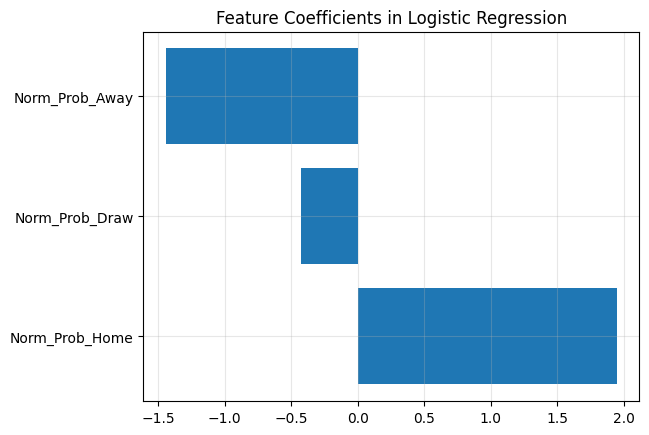

Classification Report with Class Weight Adjustment:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62        70
           1       0.23      0.54      0.33        26
           2       0.59      0.36      0.44        56

    accuracy                           0.49       152
   macro avg       0.50      0.49      0.47       152
weighted avg       0.57      0.49      0.51       152



In [151]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

def randomForestModel(weight, bool_print):
    # Adjust probabilities with the current weight
    df['Revised_Home_Prob'] = df['Norm_Prob_Home'] * (1 + (weight * df['Recent_Form_Home']))
    df['Revised_Away_Prob'] = df['Norm_Prob_Away'] * (1 + (weight * df['Recent_Form_Away']))
    
    # Recalculate probabilities
    df['Revised_Total_Prob'] = df['Revised_Home_Prob'] + df['Norm_Prob_Draw'] + df['Revised_Away_Prob']
    df['Revised_Home_Prob'] /= df['Revised_Total_Prob']
    df['Norm_Prob_Draw'] /= df['Revised_Total_Prob']
    df['Revised_Away_Prob'] /= df['Revised_Total_Prob']

    # Features: Normalized and Revised bookmaker probabilities
    features = df[['Revised_Home_Prob', 'Norm_Prob_Draw', 'Revised_Away_Prob']]
    target = df['Result_Code']

    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

    # Random Forest Model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    class_report = classification_report(y_test,preds)
    if(bool_print):
        print(f"\n Revised Random Forest Performance with form weight {weight}:")
        print(class_report)
        print("Accuracy:", accuracy)
    
    return class_report, accuracy


# The range of weights to test
weights = np.arange(-1.1, 1.1, 0.1)

best_weight = 0
best_accuracy = 0
best_class_report = ""

# Loop to find best fitting weight
for weight in weights:
    class_report, accuracy = randomForestModel(weight, False)

    # Track the best weight
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weight = weight
        best_class_report = class_report

print(f"\n Revised Random Forest Performance with form weight {best_weight}:")
print(best_class_report, best_accuracy)



# Features: Normalized and Revised bookmaker probabilities
features = df[['Revised_Home_Prob', 'Norm_Prob_Draw', 'Revised_Away_Prob']]
target = df['Result_Code']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)
# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
accuracy = accuracy_score(y_test, preds)



# Features: normalized bookmaker probabilities
features = df[['Norm_Prob_Home', 'Norm_Prob_Draw', 'Norm_Prob_Away']]
target = df['Result_Code']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

# Logistic Regression with class balancing
logreg_balanced = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
logreg_balanced.fit(X_train, y_train)
logreg_balanced_preds = logreg_balanced.predict(X_test)
logreg_balanced_probs = logreg_balanced.predict_proba(X_test)

print("Balanced Logistic Regression Performance:")
print(classification_report(y_test, logreg_balanced_preds, zero_division=0))
print("Accuracy:", accuracy_score(y_test, logreg_balanced_preds))


# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)

print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_preds))
print("Accuracy:", accuracy_score(y_test, rf_preds))

# Gradient Boosting Model (xgboost)
xgb_model = XGBClassifier(
    n_estimators=200,         # Number of trees
    learning_rate=0.05,       # Step size
    max_depth=6,              
    subsample=0.8,            
    colsample_bytree=0.8,     
    random_state=42,
    objective='multi:softprob',  
    eval_metric='mlogloss'       
)

xgb_model.fit(X_train, y_train)

# Predict class labels and probabilities
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)

print("\nXGBoost Performance:")
print(classification_report(y_test, xgb_preds, zero_division=0))
print("Accuracy:", accuracy_score(y_test, xgb_preds))

# Bar Graph of Feature Correlation Coefficients
coefficients = logreg_balanced.coef_[0]
feature_names = features.columns

plt.barh(feature_names, coefficients)
plt.title("Feature Coefficients in Logistic Regression")
plt.grid(alpha=0.3)
plt.show()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assign custom higher weight to draws
class_weights = {0: 1, 1: 2, 2: 1}

logreg = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight=class_weights)
logreg.fit(X_train, y_train)

# Evaluate model performance
logreg_weighted_preds = logreg.predict(X_test)
logreg_weighted_probs = logreg.predict_proba(X_test)
print("Classification Report with Class Weight Adjustment:")
print(classification_report(y_test, logreg_weighted_preds, zero_division=0))

### Unbalanced Logistic Regression (Retrospective)

While our main model flow uses the balanced logistic regression setup, we also trained an unbalanced logistic regression as a conceptual baseline. This helped us understand how class imbalance affected model predictions, particularly for underrepresented outcomes like draws.


In [16]:
# Unbalanced Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train logistic regression WITHOUT class balancing
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)
logreg_probs = logreg.predict_proba(X_test)

print("Unbalanced Logistic Regression Performance:")
print(classification_report(y_test, logreg_preds, zero_division=0))
print("Accuracy:", accuracy_score(y_test, logreg_preds))

Unbalanced Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.61      0.81      0.69        31
           1       0.00      0.00      0.00        19
           2       0.57      0.77      0.66        26

    accuracy                           0.59        76
   macro avg       0.39      0.53      0.45        76
weighted avg       0.44      0.59      0.51        76

Accuracy: 0.5921052631578947


### Expected Value (EV) Calculation and Backtest Simulation

We calculate the expected value (EV) for each outcome using the model’s predicted probabilities and bookmaker odds. We then simulate placing a $1 bet on each positive EV opportunity to calculate total profit and average ROI. This combined analysis helps assess whether following the model’s recommendations would have been profitable historically.


In [125]:
# Use balanced model probabilities for backtest
probs_balanced = pd.DataFrame(rf_probs, columns=['Prob_Home', 'Prob_Draw', 'Prob_Away'], index=X_test.index)
X_test_copy = X_test.copy()
X_test_copy['True_Result'] = y_test.values
X_test_copy['Home_Odds'] = df.loc[X_test_copy.index, 'Home_Odds'].values
X_test_copy['Draw_Odds'] = df.loc[X_test_copy.index, 'Draw_Odds'].values
X_test_copy['Away_Odds'] = df.loc[X_test_copy.index, 'Away_Odds'].values
X_test_copy = pd.concat([X_test_copy, probs_balanced], axis=1)

# Calculate EV
X_test_copy['EV_Home'] = (X_test_copy['Prob_Home'] * X_test_copy['Home_Odds']) - (1 - X_test_copy['Prob_Home'])
X_test_copy['EV_Draw'] = (X_test_copy['Prob_Draw'] * X_test_copy['Draw_Odds']) - (1 - X_test_copy['Prob_Draw'])
X_test_copy['EV_Away'] = (X_test_copy['Prob_Away'] * X_test_copy['Away_Odds']) - (1 - X_test_copy['Prob_Away'])
X_test_copy['Best_Bet'] = X_test_copy[['EV_Home', 'EV_Draw', 'EV_Away']].idxmax(axis=1)
X_test_copy['Best_Bet_EV'] = X_test_copy[['EV_Home', 'EV_Draw', 'EV_Away']].max(axis=1)

# Backtest: assume $1 per +EV bet
positive_ev_bets = X_test_copy[X_test_copy['Best_Bet_EV'] > 0]
def check_win(row):
    if row['Best_Bet'] == 'EV_Home' and row['True_Result'] == 0:
        return row['Home_Odds'] - 1  # Profit = odds - stake
    elif row['Best_Bet'] == 'EV_Draw' and row['True_Result'] == 1:
        return row['Draw_Odds'] - 1
    elif row['Best_Bet'] == 'EV_Away' and row['True_Result'] == 2:
        return row['Away_Odds'] - 1
    else:
        return -1  # Loss = -1 stake

positive_ev_bets['Profit'] = positive_ev_bets.apply(check_win, axis=1)
total_profit = positive_ev_bets['Profit'].sum()
num_bets = len(positive_ev_bets)
roi = total_profit / num_bets if num_bets > 0 else 0

print(f"Backtest Results on {num_bets} +EV Bets:")
print(f"Total Profit: ${total_profit:.2f}")
print(f"ROI per bet: {roi:.3f}")


Backtest Results on 152 +EV Bets:
Total Profit: $168.40
ROI per bet: 1.108


### Results and Discussion

We visualize the distribution of positive EV bets, highlight the top five bets, and summarize the average, maximum, and minimum EV across all bets. These insights help us interpret how promising the model's recommendations are and which betting opportunities stand out.


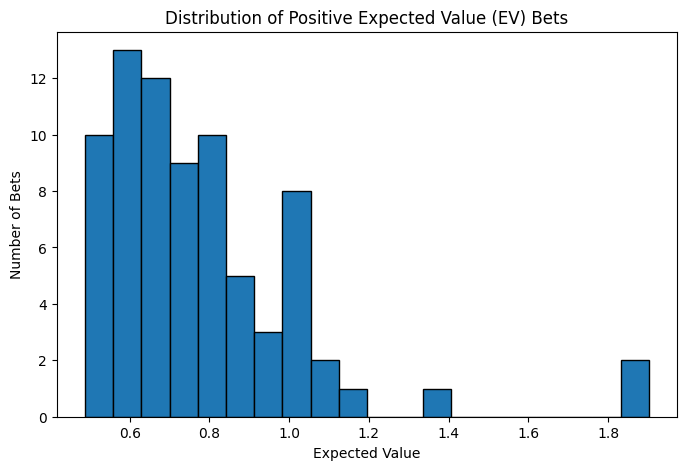

Top 5 +EV Bets:
    Best_Bet  Best_Bet_EV  Prob_Home  Prob_Draw  Prob_Away  Home_Odds  \
316  EV_Draw     1.901878   0.692645   0.241823   0.065532       1.10   
104  EV_Draw     1.901878   0.692645   0.241823   0.065532       1.10   
376  EV_Draw     1.377456   0.659161   0.264162   0.076677       1.17   
168  EV_Draw     1.124683   0.586157   0.303526   0.110317       1.30   
285  EV_Draw     1.091352   0.599469   0.298765   0.101766       1.29   

     Draw_Odds  Away_Odds  
316       11.0       19.0  
104       11.0       19.0  
376        8.0       15.0  
168        6.0        8.0  
285        6.0        9.5  

Summary of Positive EV Bets:
Average EV: 0.781
Max EV: 1.902
Min EV: 0.488


In [20]:
import matplotlib.pyplot as plt

# Plot distribution of best EV
plt.figure(figsize=(8, 5))
plt.hist(positive_ev_bets['Best_Bet_EV'], bins=20, edgecolor='k')
plt.title('Distribution of Positive Expected Value (EV) Bets')
plt.xlabel('Expected Value')
plt.ylabel('Number of Bets')
plt.show()

# Show top 5 bets by EV
top_ev_bets = positive_ev_bets.sort_values('Best_Bet_EV', ascending=False).head()
print("Top 5 +EV Bets:")
print(top_ev_bets[['Best_Bet', 'Best_Bet_EV', 'Prob_Home', 'Prob_Draw', 'Prob_Away', 'Home_Odds', 'Draw_Odds', 'Away_Odds']])

# Summary stats
mean_ev = positive_ev_bets['Best_Bet_EV'].mean()
max_ev = positive_ev_bets['Best_Bet_EV'].max()
min_ev = positive_ev_bets['Best_Bet_EV'].min()

print(f"\nSummary of Positive EV Bets:")
print(f"Average EV: {mean_ev:.3f}")
print(f"Max EV: {max_ev:.3f}")
print(f"Min EV: {min_ev:.3f}")


### Limitations and Future Work

While our project successfully identifies positive expected value (EV) betting opportunities using historical English Premier League data, there are several limitations. 

First, we rely solely on bookmaker odds and historical match outcomes, without incorporating richer features like recent team form, player injuries, or lineup changes. Our models also assume that past betting market inefficiencies will continue into the future, which may not hold true.

Additionally, our sample size is limited to one season, and we only use simple models (logistic regression, random forest). More advanced methods like gradient boosting, ensemble models, or deep learning could potentially improve predictions.

In the future, we aim to incorporate live odds data using APIs, expand the feature set with advanced team and player statistics, and perform longer-term backtests across multiple seasons to better assess strategy robustness.
